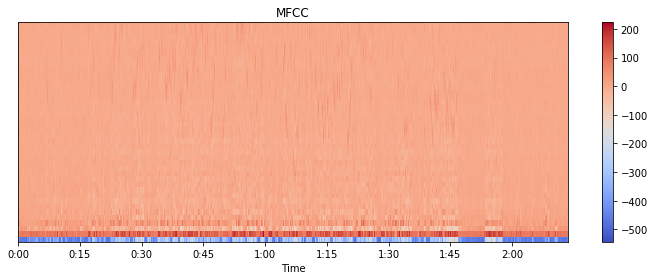

In [53]:
# Feature extraction example
import numpy as np
import librosa
import librosa.display 
import matplotlib.pyplot as plt

# Load the example clip

y, sr = librosa.load('Ses01F_impro01.wav')

librosa.feature.mfcc(y=y, sr=sr)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

librosa.feature.mfcc(S=librosa.power_to_db(S))

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [54]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('Ses01F_impro01.wav')  # File assumed to be in the same directory
signal = signal[0:int(1 * sample_rate)]  # Keep the first 3.5 seconds

In [55]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [56]:
frame_size = 0.025
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [57]:
frames *= numpy.hamming(frame_length)


In [58]:
NFFT = 512;
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [59]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

In [60]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

In [61]:
print(mfcc)

[[-72.2461037  -64.16419249 -81.57521058 ... -18.03071907 -31.14104843
    2.56452613]
 [-78.88855271 -58.61431718 -69.35888482 ... -15.18823839 -30.89742312
   -3.11768913]
 [-72.82223766 -73.56767924 -76.4155249  ... -25.93626297 -14.03534652
   20.86358999]
 ...
 [ 15.03429316   1.99142829 -56.02261688 ... -11.06053375  -1.99389028
   19.64891624]
 [ 20.44467482   8.63661462 -52.13905445 ...  -9.89750092  -1.24611915
   21.81344706]
 [ 24.73705025   9.10225084 -47.73106473 ...  -7.87309854  -1.72173337
   12.81106521]]


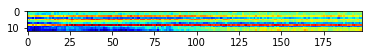

In [62]:
import matplotlib.cm as cm
plt.imshow(numpy.flipud(mfcc.T), cmap = cm.jet)


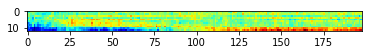

In [63]:
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
plt.imshow(numpy.flipud(mfcc.T), cmap = cm.jet)